In [1]:
import pymongo
client = pymongo.MongoClient()
table = client.clash.game_all

In [2]:
def get_team_bans(game_data):
    team_bans = {100:[],200:[]}
    for t in game_data["teams"]:
        for b in t["bans"]:
            team_bans[t["teamId"]].append(b["championId"])
    return team_bans

def get_team_picks(game_data):
    team_picks = {100:[],200:[]}
    for p in game_data["participants"]:
        team_picks[p["teamId"]].append(p["championId"])
    return team_picks

In [3]:
from static_data import ddragon
dd = ddragon.ddragon()

pick_ban_data = []

for g in table.find({"platformId":"EUW1","queueId":700},{"gameId":1,"teams":1,"participants":1}):
    team_bans = get_team_bans(g)
    team_picks = get_team_picks(g)
    
    for teamId in [100,200]:
        win = g["teams"][0 if teamId == 100 else 1]["win"] == "Win"
        
        type_ = "ban"
        for ban in team_bans[teamId]:
            
            row = {
                "gameId":g["gameId"],
                "teamId":teamId,
                "win":win,
                "type":type_,
                "championId":ban,
                "champion":dd.getChampion(ban).name if ban > 0 else "no ban"
            }
            pick_ban_data.append(row)
        
        type_ = "pick"
        for n_role , pick in enumerate(team_picks[teamId]):
            
            row = {
                "gameId":g["gameId"],
                "teamId":teamId,
                "win":win,
                "type":type_,
                "championId":pick,
                "champion":dd.getChampion(pick).name
            }
            pick_ban_data.append(row)

In [4]:
nb_games = table.find({"platformId":"EUW1","queueId":700},{"gameId":1,"teams":1,"participants":1}).count()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


In [5]:
import pandas as pd
df = pd.DataFrame(pick_ban_data)
df

,gameId,teamId,win,type,championId,champion
0,4219134238,100,True,ban,412,Thresh
1,4219134238,100,True,ban,8,Vladimir
2,4219134238,100,True,ban,145,Kai'Sa
3,4219134238,100,True,ban,38,Kassadin
4,4219134238,100,True,ban,98,Shen
...,...,...,...,...,...,...
1714655,4219320489,200,True,pick,18,Tristana
1714656,4219320489,200,True,pick,20,Nunu & Willump
1714657,4219320489,200,True,pick,45,Veigar
1714658,4219320489,200,True,pick,122,Darius


In [6]:
banrate = (
    # Selecting bans
    df[df["type"] == "ban"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most banned champions
        .sort_values("championId", ascending=False)
        ["championId"]
        # Divided by number of games to get a percentage
        /nb_games
)

banrate.head(10)

champion
Yasuo      0.410169
Morgana    0.290262
Zed        0.249647
Kai'Sa     0.244562
Pyke       0.221945
Vayne      0.213302
Jax        0.206012
Darius     0.201824
Thresh     0.198570
Caitlyn    0.197998
Name: championId, dtype: float64

In [7]:
pickrate = (
    # Selecting picks
    df[df["type"] == "pick"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
        # Divided by number of games to get a percentage
        /nb_games
)

pickrate.head(10)

champion
Xayah        0.274818
Morgana      0.262046
Kai'Sa       0.248352
Caitlyn      0.248003
Nautilus     0.218154
Rakan        0.196354
Thresh       0.182532
Malphite     0.173562
Leona        0.163753
Jarvan IV    0.163123
Name: championId, dtype: float64

In [8]:
wins = (
    # Selecting picks
    df[((df["type"] == "pick") & (df["win"]))]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
)

picks = (
    # Selecting picks
    df[df["type"] == "pick"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
)

winrate = (wins/picks).fillna(0).sort_values(ascending=False)
winrate.head(10)

champion
Blitzcrank        0.548505
Zilean            0.546213
Nunu & Willump    0.542221
Swain             0.541436
Zac               0.539064
Taric             0.536574
Ashe              0.533704
Volibear          0.533459
Mordekaiser       0.532120
Graves            0.531634
Name: championId, dtype: float64

In [9]:
presence = pickrate.add(banrate, fill_value=0).sort_values(ascending=False)
presence

champion
Morgana         0.552308
Yasuo           0.520196
Kai'Sa          0.492914
Xayah           0.456090
Caitlyn         0.446001
                  ...   
Singed          0.017485
Nidalee         0.016003
Aurelion Sol    0.015758
Kog'Maw         0.015385
Kalista         0.011536
Name: championId, Length: 146, dtype: float64

In [10]:
df_clash = pd.DataFrame([banrate,pickrate,winrate, presence]).T.fillna(0)
df_clash.columns = ["banrate", "pickrate", "winrate", "presence"]

df_clash

,banrate,pickrate,winrate,presence
Yasuo,0.410169,0.110028,0.506944,0.520196
Morgana,0.290262,0.262046,0.510505,0.552308
Zed,0.249647,0.054495,0.497217,0.304142
Kai'Sa,0.244562,0.248352,0.478208,0.492914
Pyke,0.221945,0.108593,0.503115,0.330538
...,...,...,...,...
Trundle,0.007780,0.026583,0.484423,0.034362
Nidalee,0.007313,0.008690,0.500671,0.016003
Maokai,0.006147,0.034654,0.478963,0.040801
Kog'Maw,0.005097,0.010288,0.461451,0.015385


In [11]:
pick_ban_data = []

for g in table.find({"platformId":"EUW1","queueId":420},{"gameId":1,"teams":1,"participants":1}):
    team_bans = get_team_bans(g)
    team_picks = get_team_picks(g)
    
    for teamId in [100,200]:
        win = g["teams"][0 if teamId == 100 else 1]["win"] == "Win"
        
        type_ = "ban"
        for ban in team_bans[teamId]:
            
            row = {
                "gameId":g["gameId"],
                "teamId":teamId,
                "win":win,
                "type":type_,
                "championId":ban,
                "champion":dd.getChampion(ban).name if ban > 0 else "no ban"
            }
            pick_ban_data.append(row)
        
        type_ = "pick"
        for n_role , pick in enumerate(team_picks[teamId]):
            
            row = {
                "gameId":g["gameId"],
                "teamId":teamId,
                "win":win,
                "type":type_,
                "championId":pick,
                "champion":dd.getChampion(pick).name
            }
            pick_ban_data.append(row)

In [12]:
nb_games = table.find({"platformId":"EUW1","queueId":420},{"gameId":1,"teams":1,"participants":1}).count()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


In [13]:
df = pd.DataFrame(pick_ban_data)
df

,gameId,teamId,win,type,championId,champion
0,4211002963,100,False,ban,23,Tryndamere
1,4211002963,100,False,ban,80,Pantheon
2,4211002963,100,False,ban,30,Karthus
3,4211002963,100,False,ban,246,Qiyana
4,4211002963,100,False,ban,134,Syndra
...,...,...,...,...,...,...
21226387,3167469692,200,False,pick,240,Kled
21226388,3167469692,200,False,pick,497,Rakan
21226389,3167469692,200,False,pick,412,Thresh
21226390,3167469692,200,False,pick,126,Jayce


In [14]:
banrate = df[df["type"] == "ban"].groupby("champion").count().sort_values("championId", ascending=False) ["championId"]/nb_games
banrate.head(10)

champion
Yasuo         0.554382
Pyke          0.521217
Zed           0.499372
Morgana       0.475982
Blitzcrank    0.401111
Darius        0.397612
Master Yi     0.338636
Jax           0.309658
Draven        0.300627
Evelynn       0.286633
Name: championId, dtype: float64

In [15]:
pickrate = df[df["type"] == "pick"].groupby("champion").count().sort_values("championId", ascending=False)["championId"]/nb_games

pickrate.head(10)

champion
Caitlyn    0.236826
Yasuo      0.205385
Lux        0.205252
Kai'Sa     0.203775
Jinx       0.192546
Thresh     0.186504
Ashe       0.178752
Jhin       0.178528
Morgana    0.163996
Ezreal     0.160829
Name: championId, dtype: float64

In [16]:
wins = df[((df["type"] == "pick") & (df["win"]))].groupby("champion").count().sort_values("championId", ascending=False)["championId"]

picks = df[df["type"] == "pick"].groupby("champion").count().sort_values("championId", ascending=False)["championId"]

winrate = (wins/picks).fillna(0).sort_values(ascending=False)
winrate.head(10)

champion
Blitzcrank      0.531797
Dr. Mundo       0.527482
Ashe            0.527470
Volibear        0.527227
Heimerdinger    0.526826
Vi              0.526148
Yorick          0.525589
Zac             0.525179
Jinx            0.523912
Kayle           0.523058
Name: championId, dtype: float64

In [17]:
presence = pickrate.add(banrate, fill_value=0).sort_values(ascending=False)
presence

champion
Yasuo           0.759767
Pyke            0.664594
Morgana         0.639978
Zed             0.614542
Blitzcrank      0.560546
                  ...   
Kalista         0.012760
Skarner         0.011513
Taliyah         0.011120
Aurelion Sol    0.010915
Ivern           0.010213
Name: championId, Length: 146, dtype: float64

In [18]:
df_ranked = pd.DataFrame([banrate,pickrate,winrate, presence]).T.fillna(0)
df_ranked.columns = ["banrate", "pickrate", "winrate", "presence"]

df_ranked

,banrate,pickrate,winrate,presence
Yasuo,0.554382,0.205385,0.503363,0.759767
Pyke,0.521217,0.143376,0.510393,0.664594
Zed,0.499372,0.115170,0.496257,0.614542
Morgana,0.475982,0.163996,0.498236,0.639978
Blitzcrank,0.401111,0.159435,0.531797,0.560546
...,...,...,...,...
Skarner,0.001352,0.010161,0.493880,0.011513
Maokai,0.001269,0.015329,0.499170,0.016598
Viktor,0.001178,0.014289,0.476856,0.015467
Taric,0.001116,0.015414,0.508589,0.016529


In [19]:
df_compare_banrate = pd.DataFrame({"clash":df_clash["banrate"],"ranked":df_ranked["banrate"]})

df_compare_banrate["difference"] = df_compare_banrate["clash"] - df_compare_banrate["ranked"]

df_compare_banrate.sort_values("difference")

,clash,ranked,difference
Pyke,0.221945,0.521217,-0.299273
Blitzcrank,0.145825,0.401111,-0.255286
Zed,0.249647,0.499372,-0.249724
Evelynn,0.081416,0.286633,-0.205218
Master Yi,0.133659,0.338636,-0.204977
...,...,...,...
Jinx,0.169550,0.058212,0.111337
Vayne,0.213302,0.100427,0.112875
Xayah,0.181272,0.062043,0.119229
Thresh,0.198570,0.070808,0.127762


In [20]:
df_compare_banrate.sort_values("difference")[-10:]

,clash,ranked,difference
Orianna,0.078231,0.009378,0.068854
Jhin,0.113399,0.043687,0.069711
Lucian,0.090199,0.019161,0.071038
Rakan,0.105922,0.025778,0.080144
Jarvan IV,0.097465,0.014740,0.082726
Jinx,0.169550,0.058212,0.111337
Vayne,0.213302,0.100427,0.112875
Xayah,0.181272,0.062043,0.119229
Thresh,0.198570,0.070808,0.127762
Kai'Sa,0.244562,0.104944,0.139617


In [21]:
df_compare_banrate["difference_normalized"] = df_compare_banrate["difference"]/df_compare_banrate["clash"]

df_compare_banrate.sort_values("difference_normalized")

,clash,ranked,difference,difference_normalized
Evelynn,0.081416,0.286633,-0.205218,-2.520621
no ban,0.042434,0.144426,-0.101992,-2.403530
Teemo,0.040160,0.128364,-0.088204,-2.196347
Blitzcrank,0.145825,0.401111,-0.255286,-1.750636
Brand,0.041664,0.112772,-0.071108,-1.706694
...,...,...,...,...
Sejuani,0.073006,0.007428,0.065577,0.898250
Viktor,0.011932,0.001178,0.010755,0.901298
Shen,0.052710,0.004504,0.048206,0.914557
Taric,0.013624,0.001116,0.012508,0.918116


In [22]:
df_compare_banrate.sort_values("difference_normalized")[-10:]

,clash,ranked,difference,difference_normalized
Jarvan IV,0.097465,0.014740,0.082726,0.848769
Ornn,0.021532,0.002993,0.018539,0.860980
Sion,0.016050,0.001955,0.014095,0.878187
Orianna,0.078231,0.009378,0.068854,0.880128
Nami,0.048441,0.005486,0.042955,0.886740
Sejuani,0.073006,0.007428,0.065577,0.898250
Viktor,0.011932,0.001178,0.010755,0.901298
Shen,0.052710,0.004504,0.048206,0.914557
Taric,0.013624,0.001116,0.012508,0.918116
Taliyah,0.009436,0.000706,0.008731,0.925213


In [23]:
df_compare_banrate["ranked"].hist(bins=50, range=(0, 0.6))

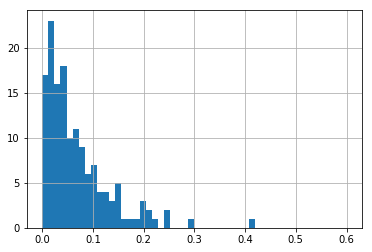

In [24]:
df_compare_banrate["clash"].hist(bins=50, range=(0, 0.6))

In [25]:
pick_ban_data = []

for g in table.find({"platformId":"EUW1","queueId":440},{"gameId":1,"teams":1,"participants":1}):
    team_bans = get_team_bans(g)
    team_picks = get_team_picks(g)
    
    for teamId in [100,200]:
        win = g["teams"][0 if teamId == 100 else 1]["win"] == "Win"
        
        type_ = "ban"
        for ban in team_bans[teamId]:
            
            row = {
                "gameId":g["gameId"],
                "teamId":teamId,
                "win":win,
                "type":type_,
                "championId":ban,
                "champion":dd.getChampion(ban).name if ban > 0 else "no ban"
            }
            pick_ban_data.append(row)
        
        type_ = "pick"
        for n_role , pick in enumerate(team_picks[teamId]):
            
            row = {
                "gameId":g["gameId"],
                "teamId":teamId,
                "win":win,
                "type":type_,
                "championId":pick,
                "champion":dd.getChampion(pick).name
            }
            pick_ban_data.append(row)

In [26]:
nb_games = table.find({"platformId":"EUW1","queueId":440},{"gameId":1,"teams":1,"participants":1}).count()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


In [27]:
df = pd.DataFrame(pick_ban_data)
df

,gameId,teamId,win,type,championId,champion
0,4208070956,100,True,ban,8,Vladimir
1,4208070956,100,True,ban,555,Pyke
2,4208070956,100,True,ban,121,Kha'Zix
3,4208070956,100,True,ban,24,Jax
4,4208070956,100,True,ban,127,Lissandra
...,...,...,...,...,...,...
4953507,3166191696,200,True,pick,223,Tahm Kench
4953508,3166191696,200,True,pick,83,Yorick
4953509,3166191696,200,True,pick,68,Rumble
4953510,3166191696,200,True,pick,33,Rammus


In [28]:
banrate = (
    # Selecting bans
    df[df["type"] == "ban"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most banned champions
        .sort_values("championId", ascending=False)
        ["championId"]
        # Divided by number of games to get a percentage
        /nb_games
)

banrate.head(10)

champion
Yasuo         0.553404
Pyke          0.539664
Morgana       0.529813
Zed           0.520357
Blitzcrank    0.414232
Darius        0.413211
Draven        0.313279
Master Yi     0.279235
Jax           0.263037
Akali         0.262621
Name: championId, dtype: float64

In [29]:
pickrate = (
    # Selecting picks
    df[df["type"] == "pick"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
        # Divided by number of games to get a percentage
        /nb_games
)

pickrate.head(10)

champion
Caitlyn       0.217470
Yasuo         0.213917
Thresh        0.199487
Kai'Sa        0.198300
Lux           0.186854
Lee Sin       0.180257
Blitzcrank    0.176845
Ezreal        0.172012
Jhin          0.171080
Ashe          0.169570
Name: championId, dtype: float64

In [30]:
wins = (
    # Selecting picks
    df[((df["type"] == "pick") & (df["win"]))]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
)

picks = (
    # Selecting picks
    df[df["type"] == "pick"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
)

winrate = (wins/picks).fillna(0).sort_values(ascending=False)
winrate.head(10)

champion
Yorick      0.540934
Zac         0.536888
Volibear    0.535655
Vi          0.533701
Urgot       0.532035
Kayle       0.531258
Nami        0.530541
Malzahar    0.529808
Ashe        0.529465
Jinx        0.527966
Name: championId, dtype: float64

In [31]:
presence = pickrate.add(banrate, fill_value=0).sort_values(ascending=False)
presence

champion
Yasuo           0.767321
Pyke            0.691489
Morgana         0.679716
Zed             0.628161
Blitzcrank      0.591077
                  ...   
Taric           0.018673
Kog'Maw         0.018467
Aurelion Sol    0.018060
Skarner         0.015948
Taliyah         0.014176
Name: championId, Length: 146, dtype: float64

In [32]:
df_flex = pd.DataFrame([banrate,pickrate,winrate, presence]).T.fillna(0)
df_flex.columns = ["banrate", "pickrate", "winrate", "presence"]

df_flex

,banrate,pickrate,winrate,presence
Yasuo,0.553404,0.213917,0.503897,0.767321
Pyke,0.539664,0.151825,0.508457,0.691489
Morgana,0.529813,0.149903,0.505064,0.679716
Zed,0.520357,0.107804,0.489158,0.628161
Blitzcrank,0.414232,0.176845,0.523321,0.591077
...,...,...,...,...
Trundle,0.001995,0.020212,0.501598,0.022206
Taric,0.001926,0.016747,0.518804,0.018673
Maokai,0.001768,0.017523,0.499309,0.019291
Viktor,0.001728,0.017260,0.494269,0.018988


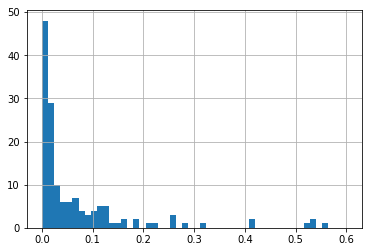

In [33]:
banrate.hist(bins=50, range=(0, 0.6))

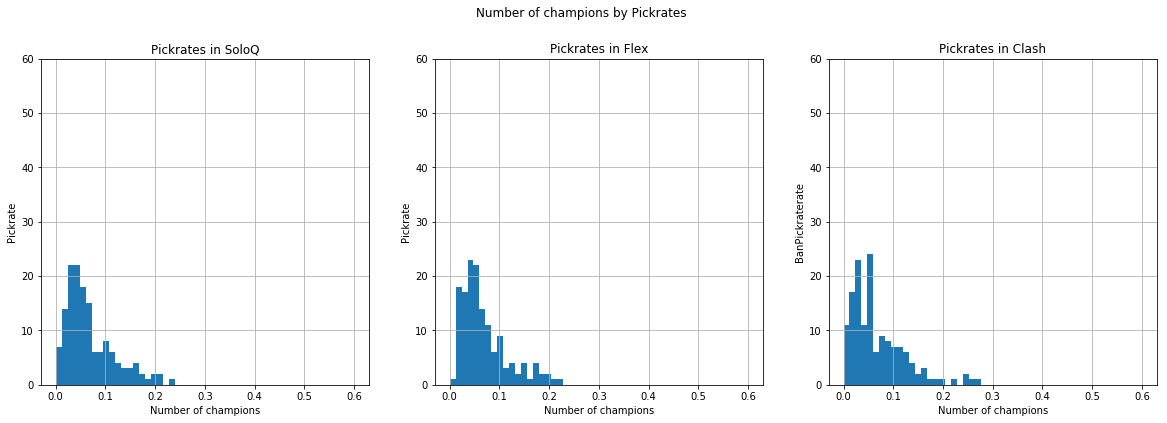

In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3)

df_ranked["pickrate"].hist(bins=50, figsize=(6,6), range=(0, 0.6), ax=axes[0])
axes[0].set_ylim([0,60])
axes[0].set_ylabel("Pickrate")
axes[0].set_xlabel("Number of champions")
axes[0].set_title("Pickrates in SoloQ")

pickrate.hist(bins=50, range=(0, 0.6), figsize=(6,6), ax=axes[1])
axes[1].set_ylim([0,60])
axes[1].set_ylabel("Pickrate")
axes[1].set_xlabel("Number of champions")
axes[1].set_title("Pickrates in Flex")

df_clash["pickrate"].hist(bins=50, figsize=(6,6), range=(0, 0.6), ax=axes[2])
axes[2].set_ylim([0,60])
axes[2].set_ylabel("BanPickraterate")
axes[2].set_xlabel("Number of champions")
axes[2].set_title("Pickrates in Clash")

fig.suptitle("Number of champions by Pickrates", y=1)
fig.set_size_inches(20, 6)
fig.show()

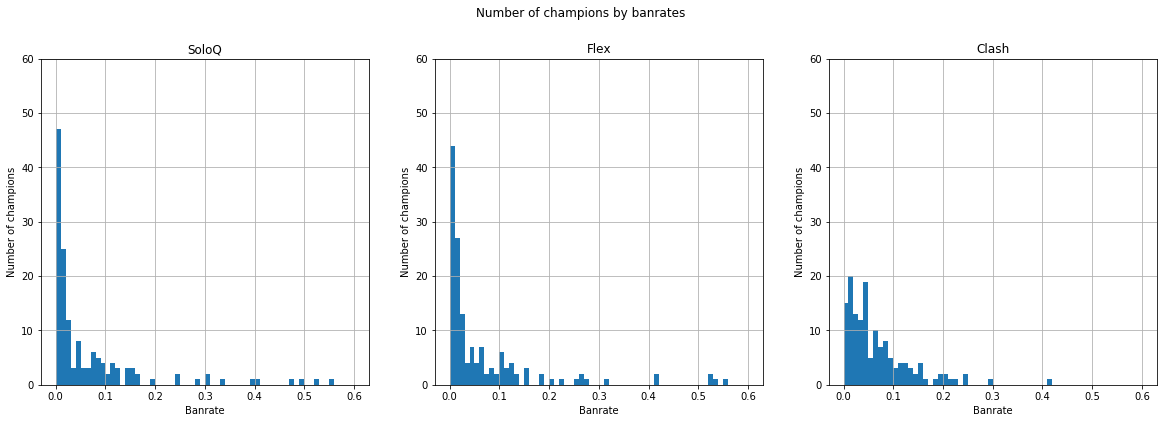

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3)

df_ranked["banrate"].hist(bins=60, figsize=(6,6), range=(0, 0.6), ax=axes[0])
axes[0].set_ylim([0,60])
axes[0].set_xlabel("Banrate")
axes[0].set_ylabel("Number of champions")
axes[0].set_title("SoloQ")

banrate.hist(bins=60, range=(0, 0.6), figsize=(6,6), ax=axes[1])
axes[1].set_ylim([0,60])
axes[1].set_xlabel("Banrate")
axes[1].set_ylabel("Number of champions")
axes[1].set_title("Flex")

df_clash["banrate"].hist(bins=60, figsize=(6,6), range=(0, 0.6), ax=axes[2])
axes[2].set_ylim([0,60])
axes[2].set_xlabel("Banrate")
axes[2].set_ylabel("Number of champions")
axes[2].set_title("Clash")

fig.suptitle("Number of champions by banrates", y=1)
fig.set_size_inches(20, 6)
fig.show()

In [36]:
table_masteries = client.clash.masteries

champion_levels_by_summonerId = {}
for m in table_masteries.find():
    champion_levels_by_summonerId[m["summonerId"]] = m["championLevels"]

In [37]:
nb_bans = 0
nb_bans_against_lvl_7 = 0
nb_team_lvl_7 = []

def get_team_bans_(game_data):
    team_bans = {100:[],200:[]}
    for t in game_data["teams"]:
        for b in t["bans"]:
            if b["championId"] > 0:
                team_bans[t["teamId"]].append(b["championId"])
    return team_bans

def get_team_lvl_7(game_data):
    team_lvl_7 = {100:set(),200:set()}
    
    participantId_to_teamId = {}
    for p in game_data["participants"]:
        participantId_to_teamId[p["participantId"]] = p["teamId"]
    
    for p in game_data["participantIdentities"]:
        for c in champion_levels_by_summonerId[p["player"]["summonerId"]]["7"]:
            team_lvl_7[participantId_to_teamId[p["participantId"]]].add(c)
    
    return team_lvl_7

for g in table.find({"platformId":"EUW1","queueId":700},{"gameId":1,"teams":1,"participants":1,"participantIdentities":1}):
    team_bans = get_team_bans_(g)
    team_lvl_7 = get_team_lvl_7(g)
    
    for teamId in [100,200]:
        nb_team_lvl_7.append(team_lvl_7[teamId])
        other_team = 100 if teamId == 200 else 200
        type_ = "ban"
        for ban in team_bans[teamId]:
            nb_bans += 1
            if ban in team_lvl_7[other_team]:
                nb_bans_against_lvl_7 += 1

In [38]:
print("Part of bans against champions with Mastery 7 on the other team : ", nb_bans_against_lvl_7/nb_bans)

Part of bans against champions with Mastery 7 on the other team :  0.6009333576980925


In [39]:
pd.Series([len(i) for i in nb_team_lvl_7]).mean()

27.13847060058554

In [40]:
otp = {}
for m in table_masteries.find():
    if m["details"][0]["championPoints"] > (sum([i["championPoints"] for i in m["details"]])/2):
        otp[m["summonerId"]] = m["details"][0]["championId"]

In [41]:
len(otp)

2324

In [42]:
otp_playing = 0
opt_playing_champion = 0
opt_playing_champion_winning = 0
opt_banned = 0

for g in table.find({"platformId":"EUW1","queueId":700},{"gameId":1,"teams":1,"participants":1,"participantIdentities":1}):
    team_bans = get_team_bans_(g)
    
    participants_summonerId = {}
    for p in g["participantIdentities"]:
        participants_summonerId[p["participantId"]] = p["player"]["summonerId"]
    
    for p in g["participants"]:
        if participants_summonerId[p["participantId"]] in otp.keys():
            otp_playing += 1
            
            other_team = 100 if p["teamId"] == 200 else 200
            if otp[participants_summonerId[p["participantId"]]] in team_bans[other_team]:
                opt_banned += 1
            
            if otp[participants_summonerId[p["participantId"]]] == p["championId"]:
                opt_playing_champion += 1
                if p["stats"]["win"]:
                    opt_playing_champion_winning += 1

In [43]:
print("OTP having their champion banned", opt_banned/otp_playing)
print("OTP playing their champion", opt_playing_champion/otp_playing)
print("OTP playing", otp_playing)
print("OTP winning with their champion", opt_playing_champion_winning/opt_playing_champion)

OTP having their champion banned 0.6887592788971368
OTP playing their champion 0.19273594909862143
OTP playing 7544
OTP winning with their champion 0.48762035763411277


In [44]:
df_clash.sort_values("pickrate")[-10:]

,banrate,pickrate,winrate,presence
Jarvan IV,0.097465,0.163123,0.517912,0.260588
Leona,0.096567,0.163753,0.511717,0.260320
Malphite,0.152053,0.173562,0.511559,0.325616
Thresh,0.198570,0.182532,0.511790,0.381102
Rakan,0.105922,0.196354,0.508257,0.302276
Nautilus,0.112092,0.218154,0.518526,0.330246
Caitlyn,0.197998,0.248003,0.509171,0.446001
Kai'Sa,0.244562,0.248352,0.478208,0.492914
Morgana,0.290262,0.262046,0.510505,0.552308
Xayah,0.181272,0.274818,0.511141,0.456090


In [45]:
df_ranked.sort_values("pickrate")[-10:]

,banrate,pickrate,winrate,presence
Ezreal,0.042795,0.160829,0.459059,0.203624
Morgana,0.475982,0.163996,0.498236,0.639978
Jhin,0.043687,0.178528,0.516474,0.222215
Ashe,0.027409,0.178752,0.527470,0.206161
Thresh,0.070808,0.186504,0.482922,0.257313
Jinx,0.058212,0.192546,0.523912,0.250758
Kai'Sa,0.104944,0.203775,0.473684,0.308720
Lux,0.060195,0.205252,0.501990,0.265448
Yasuo,0.554382,0.205385,0.503363,0.759767
Caitlyn,0.169502,0.236826,0.504824,0.406328


In [46]:
df_compare_pickrate = pd.DataFrame({"clash":df_clash["pickrate"],"ranked":df_ranked["pickrate"]})

df_compare_pickrate["difference"] = df_compare_pickrate["clash"] - df_compare_pickrate["ranked"]

df_compare_pickrate.sort_values("difference")

,clash,ranked,difference
Yasuo,0.110028,0.205385,-0.095358
Teemo,0.024751,0.100533,-0.075782
Master Yi,0.040358,0.111422,-0.071064
Lux,0.137660,0.205252,-0.067592
Lee Sin,0.087749,0.154168,-0.066419
...,...,...,...
Nautilus,0.218154,0.122965,0.095189
Sejuani,0.118857,0.021934,0.096923
Morgana,0.262046,0.163996,0.098050
Rakan,0.196354,0.093430,0.102924


In [47]:
from tabulate import tabulate

In [48]:
print(tabulate(df_compare_pickrate.sort_values("difference").format({'clash': "{:.2%}"}), tablefmt="pipe", headers="keys"))

AttributeError: 'DataFrame' object has no attribute 'format'

In [ ]:
df_compare_pickrate_styled = pd.DataFrame()

In [ ]:
df_compare_pickrate_styled["clash"] = df_compare_pickrate['clash'].map('{:,.2%}'.format)
df_compare_pickrate_styled["ranked"] = df_compare_pickrate['ranked'].map('{:,.2%}'.format)
df_compare_pickrate_styled["difference_n"] = df_compare_pickrate['difference']*100
df_compare_pickrate_styled["difference"] = df_compare_pickrate_styled["difference_n"].map('{:,.2}'.format)

In [ ]:
df_compare_pickrate_styled

In [ ]:
print(tabulate(df_compare_pickrate_styled.sort_values("difference_n")[["clash","ranked","difference"]], tablefmt="pipe", headers="keys"))

In [ ]:
df_compare_banrate_styled = pd.DataFrame()
df_compare_banrate_styled["clash"] = df_compare_banrate['clash'].map('{:,.2%}'.format)
df_compare_banrate_styled["ranked"] = df_compare_banrate['ranked'].map('{:,.2%}'.format)
df_compare_banrate_styled["difference_n"] = df_compare_banrate['difference']*100
df_compare_banrate_styled["difference"] = df_compare_banrate_styled["difference_n"].map('{:,.2}'.format)

In [ ]:
print(tabulate(df_compare_banrate_styled.sort_values("difference_n")[["clash","ranked","difference"]], tablefmt="pipe", headers="keys"))

In [ ]:
df_ranked

In [ ]:
df_ranked_style = pd.DataFrame()
df_ranked_style["Banrate"] = df_ranked['banrate'].map('{:,.2%}'.format)
df_ranked_style["Pickrate"] = df_ranked['pickrate'].map('{:,.2%}'.format)
df_ranked_style["Winrate"] = df_ranked['winrate'].map('{:,.2%}'.format)
df_ranked_style["Presence"] = df_ranked["presence"].map('{:,.2%}'.format)
df_ranked_style["presence_n"] = df_ranked["presence"]

In [ ]:
print(tabulate(df_ranked_style.sort_values("presence_n", ascending=False)[["Banrate","Pickrate","Winrate","Presence"]], tablefmt="pipe", headers="keys"))

In [ ]:
df_clash_style = pd.DataFrame()
df_clash_style["Banrate"] = df_clash['banrate'].map('{:,.2%}'.format)
df_clash_style["Pickrate"] = df_clash['pickrate'].map('{:,.2%}'.format)
df_clash_style["Winrate"] = df_clash['winrate'].map('{:,.2%}'.format)
df_clash_style["Presence"] = df_clash["presence"].map('{:,.2%}'.format)
df_clash_style["presence_n"] = df_clash["presence"]

In [ ]:
print(tabulate(df_clash_style.sort_values("presence_n", ascending=False)[["Banrate","Pickrate","Winrate","Presence"]], tablefmt="pipe", headers="keys"))